In [1]:
# не знаю, куда вставить этот код, он для генерации данных, пускай будет тут
# обрати внимание, что все библиотеки уже импортированы

from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import random as r
import numpy as np

def gen(N_AXES=2, N_CLUSTERS=3, N_ROWS=1000, seed=57):
    
    r.seed(seed)

    sigmas = np.array([r.randint(5, 10) for i in range(N_CLUSTERS)])
    centers = np.array([[r.random() * 100 for i in range(N_AXES)] for i in range(N_CLUSTERS)])

    df = DataFrame([[0 for i in range(N_AXES + 1)] for i in range(N_ROWS)])
    df.rename(columns = {N_AXES : "cluster"}, inplace=True)

    s = "abcdefghijklmnopqrstuvwxyz"
    for i in range(N_AXES):
        df.rename(columns = {i : s[i]}, inplace=True)

    for i in range(N_ROWS):
        row = df.loc[i].copy()
        row["cluster"] = r.randint(0, N_CLUSTERS - 1)

        for j in range(N_AXES):
            row[j] = r.gauss(centers[int(row["cluster"])][j], sigmas[int(row["cluster"])])

        df.loc[i] = row
    return df

# Методы кластеризации. Метод k средних
В анализе данных очень важное место занимает кластеризация данных. Если своими словами, кластеризация – разделение выборки на кластеры, то есть на участки, схожие по свойствам. На [википедии](https://ru.wikipedia.org/wiki/Кластерный_анализ) написано подробно, но не очень понятно.

Сегодняшний урок посвящен одному конкретному алгоритму кластеризации – Методу k средних. <br/> Основная идея этого метода — итеративное повторение двух шагов:
1. Распределение объектов выборки по кластерам
2. Пересчёт центров кластеров 

В начале работы алгоритма выбираются *K* случайных центров в пространстве признаков. Каждый объект выборки относят к тому кластеру, к центру которого объект оказался ближе. Далее центры кластеров пересчитывают как среднее арифметическое векторов признаков всех вошедших в этот кластер объектов (то есть центр масс кластера). Как только мы обновили центры кластеров, объекты заново перераспределяются по ним, а затем можно снова уточнить положение центров. Процесс продолжается до тех пор, пока центры кластеров не перестанут меняться.
![Гифка1](https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p1.gif)
## Выбор начального приближения
Первый вопрос при выборе начального положения центров — как, выбирая центры из некоторого случайного распределения, не попасть в область пространства признаков, где нет точек выборки. Базовое решение — просто выбрать в качестве центров какие-то из объектов выборки.

Вторая потенциальная проблема — кучное размещение центров. В этом случае их начальное положение с большой вероятностью окажется далёким от итогового положения центров кластеров. Например, для таких изначальных положений центров
<img src="https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p2.png" width="500" height="500">
мы получим неправильную кластеризацию.
<img src="https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p3.png" width="500" height="500">
Чтобы бороться с этим явлением, выгодно брать максимально удаленные друг от друга центры.

## Как посчитать расстояние между двумя точками

Расстояние между двумя точками – Евклидово, то есть ищется по формуле
$$ \sqrt{(x_1 - x_2) ^ 2 + (y_1 - y_2) ^ 2}, $$ где $x_1$ и $y_1$, $x_2$ и $y_2$ это координаты двух точек. 

В случае, когда осей больше двух: 
$$ \sqrt{\sum_{i=1}^n (a_i - b_i) ^ 2}, $$ где *a* и *b* – точки с координатами $ (a_1, a_2... a_n) $ и $ (b_1, b_2... b_n) $.

Для примера посчитаем расстояние между двумя точками.

In [2]:
df1 = gen(5, N_ROWS=2)
df1

,a,b,c,d,e,cluster
0,86.629161,26.947834,44.651728,-0.597717,83.678195,2
1,89.271643,53.749007,39.124357,20.741712,83.879048,2


Столбец *cluster* пока можно игнорировать. Допустим, что одна из этих точек – наш центр, а вторая – одна из точек выборки. Нам нужно найти расстояние между ними.

In [3]:
# записал точки в переменные
a = df1.loc[0][:-1]
b = df1.loc[1][:-1]
a, b

(a    86.629161
 b    26.947834
 c    44.651728
 d    -0.597717
 e    83.678195
 Name: 0, dtype: float64,
 a    89.271643
 b    53.749007
 c    39.124357
 d    20.741712
 e    83.879048
 Name: 1, dtype: float64)

In [4]:
# посчитал Евклидово расстояние
s = 0
for i in range(a.size):
    s += (a[i] - b[i]) ** 2

np.sqrt(s)

34.8030026416825

## Как получить результирующий вектор

In [5]:
df2 = gen(N_ROWS=4)
df2

,a,b,cluster
0,43.453515,49.143660,1
1,105.822617,39.155865,2
2,42.231481,46.263037,1
3,89.478957,38.420069,2


Пускай у нас есть 4 точки. Столбец *cluster* пока не имеет значения. Допустим, наш центр стоял на координатах (50, 50), посчитаем, куда и на сколько ему нужно сдвинуться.

In [6]:
center = [50, 50]
res_vector = [0, 0] # здесь будет результирующий вектор

# так находим сумму
for i, row in df2.iterrows():
    res_vector[0] += row[0] - center[0]
    res_vector[1] += row[1] - center[1]

# так находим среднее (потому что 4 строчки)
res_vector[0] /= 4 
res_vector[1] /= 4

res_vector

[20.246642635047866, -6.754342275407652]

Эти два числа показывают, на сколько нужно сдвинуть центр по каждой из координат. Я не буду здесь реализовывать алгоритм для большего числа измерений, хочу, чтобы это сделал ты.

---

## Задачи для самостоятельного выполнения

Написать кластеризацию методом k средних для нижеследующих фреймов (это может быть один код, а может быть два разных, как удобно)

### 1

In [7]:
df_1 = gen()
df_1

,a,b,cluster
0,43.453515,49.143660,1
1,105.822617,39.155865,2
2,42.231481,46.263037,1
3,89.478957,38.420069,2
4,35.881109,38.806546,1
...,...,...,...
995,103.939801,48.954523,2
996,24.117405,48.233967,1
997,53.216795,21.539815,0
998,26.760307,47.781917,1


На графике видно распределение данных, он для твоего удобства, визуализация это всегда хорошо.

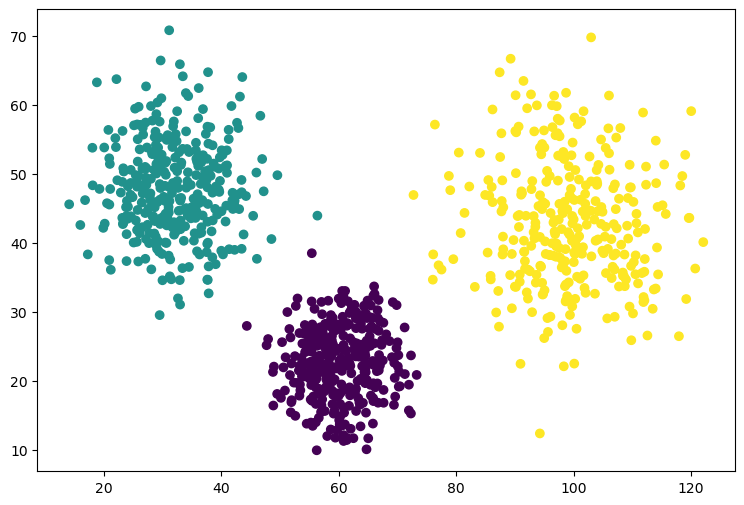

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x=df_1["a"], y=df_1["b"], c=df_1["cluster"])
plt.show()

### 2

In [9]:
df_2 = gen(4, 4)
df_2

,a,b,c,d,cluster
0,78.397546,40.189727,55.911517,35.831526,2
1,103.719386,48.534106,84.042506,1.666967,1
2,90.502290,73.682812,77.366861,93.312587,3
3,68.574104,55.525096,48.325597,42.054667,2
4,106.550783,66.648036,65.398012,61.821630,3
...,...,...,...,...,...
995,102.267243,61.556026,70.285435,72.106851,3
996,96.622468,49.405848,83.750657,57.981646,3
997,105.587189,51.567786,74.314438,63.270501,3
998,69.202931,49.716664,51.937708,31.514600,2


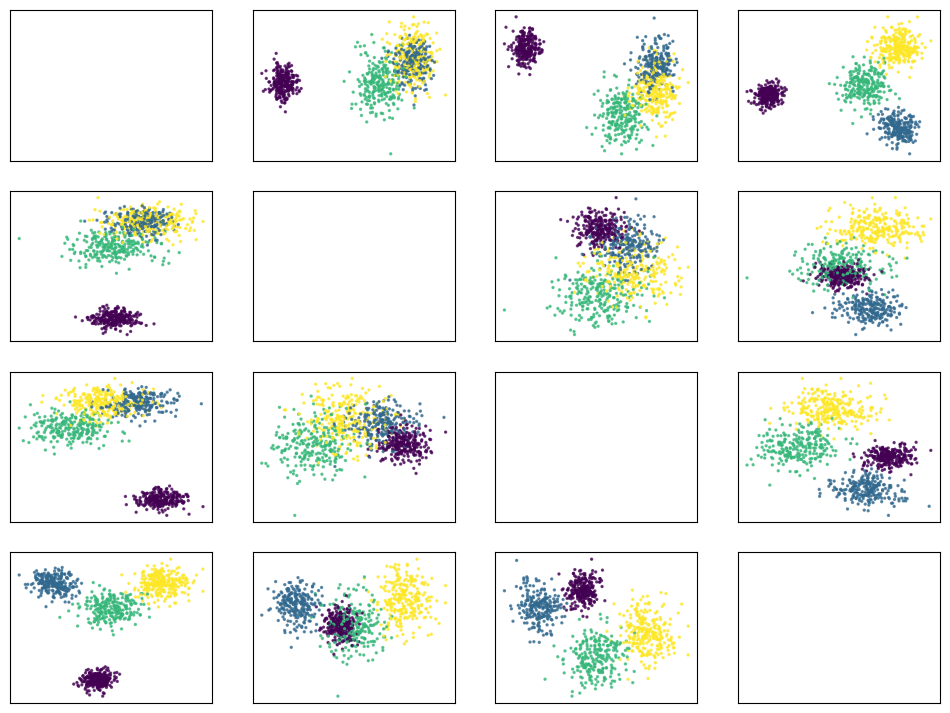

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        
        if i == j:
            continue
            
        s = "abcde"
        axes[i, j].scatter(x=df_2[s[i]], y=df_2[s[j]], c=df_2["cluster"], s=2, alpha=0.7)

plt.show()

Эти графики показывают расположение этих точек с разных сторон. Четырехмерное пространство не представить на двумерном графике, но можно представить на нескольких двумерных. Замечу, что на нижней строчке на первом и третьем графике особенно хорошо видны кластеры, лучше, чем на остальных. 

Это непростые задачи, особенно вторая, желаю тебе удачи, если что – пиши с вопросами.

**Наверное, удобнее будет решать задачи, скачав этот файл, так что пускай сразу под этой записью будет твой прекрасный код! (:**